In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine

# Get the current working directory
current_dir = os.getcwd()

# Append the parent directory to sys.path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)


# ignore warrnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import Postgres connection from DB_connection folder
from DB_connection.connection import PostgresConnection

In [3]:
# Create an instance of the PostgresConnection class and connect to the database
db=PostgresConnection()
db.connect()

Connected to PostgreSQL database


In [4]:
# query to retrive all the data from xdr_data table
query='select * from xdr_data'
db.execute_query(query)

Query executed successfully


In [5]:
# Assign the data to a dataframe named 'df'
df=db.fetch_data(query)
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


### User Engagement 

In [6]:
df['Total Duration']=df['Total UL (Bytes)']+df['Total DL (Bytes)']
# Assume df is the DataFrame containing the dataset
engagement_df = df.groupby('MSISDN/Number').agg({
    'Bearer Id': 'count',  # This will give us the number of sessions per user
    'Total Duration': 'sum',  # Total duration of all sessions
    'Total UL (Bytes)': 'sum',  # Total upload bytes
    'Total DL (Bytes)': 'sum',  # Total download bytes
}).reset_index()

# Calculate the total traffic per user
engagement_df['Total Traffic (Bytes)'] = engagement_df['Total UL (Bytes)'] + engagement_df['Total DL (Bytes)']

# Rename columns for better understanding
engagement_df.rename(columns={'Bearer Id': 'Session Frequency'}, inplace=True)

# Top 10 customers per engagement metric
top10_sessions = engagement_df.nlargest(10, 'Session Frequency')
top10_duration = engagement_df.nlargest(10, 'Total Duration')
top10_traffic = engagement_df.nlargest(10, 'Total Traffic (Bytes)')

In [7]:
# Selecting only the relevant columns for normalization
metrics = ['Session Frequency', 'Total Duration', 'Total Traffic (Bytes)']
scaler = MinMaxScaler()
engagement_df[metrics] = scaler.fit_transform(engagement_df[metrics])

# Applying K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_df['Engagement Cluster'] = kmeans.fit_predict(engagement_df[metrics])

  File "e:\Kiffya_10_acc\Week 2\TellCo-Telecom-Analysis\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Getahun\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Getahun\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Getahun\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [8]:
engagement_df

,MSISDN/Number,Session Frequency,Total Duration,Total UL (Bytes),Total DL (Bytes),Total Traffic (Bytes),Engagement Cluster
0,3.360100e+10,0.055556,0.095931,36053108.0,8.426375e+08,0.095931,2
1,3.360100e+10,0.055556,0.014026,36104459.0,1.207552e+08,0.014026,0
2,3.360100e+10,0.055556,0.063851,39306820.0,5.566597e+08,0.063851,0
3,3.360101e+10,0.055556,0.044148,20327526.0,4.019932e+08,0.044148,0
4,3.360101e+10,0.111111,0.161598,94280527.0,1.363130e+09,0.161598,2
...,...,...,...,...,...,...,...
106851,3.379000e+10,0.055556,0.077317,26716429.0,6.879252e+08,0.077317,2
106852,3.379000e+10,0.055556,0.050727,35732243.0,4.445751e+08,0.050727,0
106853,3.197021e+12,0.055556,0.022566,37295915.0,1.948281e+08,0.022566,0
106854,3.370000e+14,0.055556,0.063887,56652839.0,5.396350e+08,0.063887,0


In [9]:
# Calculate the centroids of each engagement cluster
engagement_centroids = engagement_df.groupby('Engagement Cluster')[metrics].mean()

# Display the centroids for each cluster
print(engagement_centroids)

# Sum the normalized metrics for each cluster to get a measure of total engagement
engagement_centroids['Total Engagement Score'] = engagement_centroids.sum(axis=1)

# Identify the cluster with the lowest total engagement score
least_engaged_cluster = engagement_centroids['Total Engagement Score'].idxmin()

print(f"The least engaged cluster is: {least_engaged_cluster}")


                    Session Frequency  Total Duration  Total Traffic (Bytes)
Engagement Cluster                                                          
0                            0.057815        0.037848               0.037848
1                            0.194881        0.218017               0.218017
2                            0.081787        0.097088               0.097088
The least engaged cluster is: 0


#### User Experiences

In [10]:
user_experience_df=pd.read_csv("user_experience_data.csv")
user_experience_df.head()

,Customer Number,Avg TCP DL Retransmission,Avg TCP UL Retransmission,Avg RTT DL,Avg RTT UL,Avg Throughput DL,Avg Throughput UL,Handset Type,Experience Cluster
0,3.360100e+10,2.080991e+07,759658.664811,46.000000,0.000000,37.0,39.0,Huawei P20 Lite Huawei Nova 3E,1
1,3.360100e+10,2.080991e+07,759658.664811,30.000000,1.000000,48.0,51.0,Apple iPhone 7 (A1778),1
2,3.360100e+10,2.080991e+07,759658.664811,109.795706,17.662883,48.0,49.0,undefined,1
3,3.360101e+10,1.066000e+03,759658.664811,69.000000,15.000000,204.0,44.0,Apple iPhone 5S (A1457),1
4,3.360101e+10,1.507977e+07,390430.332406,57.000000,2.500000,20197.5,8224.5,Apple iPhone Se (A1723),2


In [29]:
# Compute the mean values for each cluster
cluster_means = user_experience_df.groupby('Experience Cluster')[metrics].mean()

# Determine the worst experience cluster
# Define worst experience based on highest average values for the metrics
# Example: Highest average RTT, TCP retransmission, etc.
worst_experience_cluster = cluster_means.mean(axis=1).idxmax()

In [30]:
# # Determine worst experience cluster
# worst_experience_cluster=get_worst_experience_cluster(user_experience_df,'Experience Cluster',metrics)
# print(worst_experience_cluster)

In [31]:
from sklearn.metrics.pairwise import euclidean_distances

# Assuming you have the user engagement data (user_engagement_df) and experience data (user_experience_df)

# Step 1: Calculate the centroids of the least engaged cluster and worst experience cluster
least_engaged_centroid = engagement_df[engagement_df['Engagement Cluster'] == least_engaged_cluster].mean().values
# Get the centroid for the worst experience cluster
worst_experience_centroid = user_experience_df[user_experience_df['Experience Cluster'] == worst_experience_cluster][metrics].mean().values

In [26]:
# Task 4.1 - Assign engagement and experience scores
# Calculate the center of each engagement cluster
engagement_centers = engagement_df.groupby('Engagement Cluster').mean().drop(columns=['MSISDN/Number'])

# Calculate engagement scores
engagement_scores = []
for index, row in engagement_df.iterrows():
    cluster_center = engagement_centers.loc[row['Engagement Cluster']]
    score = np.sqrt(np.sum((row[engagement_df.columns != 'MSISDN/Number'] - cluster_center) ** 2))
    engagement_scores.append(score)
engagement_df['Engagement Score'] = engagement_scores


In [32]:
# Calculate the center of each experience cluster
experience_centers = user_experience_df.groupby('Experience Cluster').mean().drop(columns=['MSISDN/Number'])

# Calculate experience scores
experience_scores = []
for index, row in user_experience_df.iterrows():
    cluster_center = experience_centers.loc[row['Experience Cluster']]
    score = np.sqrt(np.sum((row[user_experience_df.columns != 'MSISDN/Number'] - cluster_center) ** 2))
    experience_scores.append(score)
user_experience_df['Experience Score'] = experience_scores



TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# Task 4.2 - Calculate satisfaction score and report top 10 satisfied customers
merged_df = engagement_df.merge(user_experience_df, on='UserID', suffixes=('_engagement', '_experience'))
merged_df['Satisfaction Score'] = (merged_df['Engagement Score'] + merged_df['Experience Score']) / 2
top_10_satisfied = merged_df.nlargest(10, 'Satisfaction Score')
print(top_10_satisfied)

In [ ]:
# Task 4.3 - Build a regression model to predict the satisfaction score
X = merged_df[['Engagement Score', 'Experience Score']]
y = merged_df['Satisfaction Score']
model = LinearRegression()
model.fit(X, y)
print("Regression model coefficients:", model.coef_)
print("Regression model intercept:", model.intercept_)

In [ ]:
# Task 4.4 - K-means clustering on the engagement & experience scores
X_cluster = merged_df[['Engagement Score', 'Experience Score']]
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)
kmeans = KMeans(n_clusters=2, random_state=42)
merged_df['Cluster'] = kmeans.fit_predict(X_cluster_scaled)

# Task 4.5 - Aggregate the average satisfaction & experience score per cluster
cluster_aggregation = merged_df.groupby('Cluster').agg({
    'Satisfaction Score': 'mean',
    'Experience Score': 'mean'
})
print(cluster_aggregation)

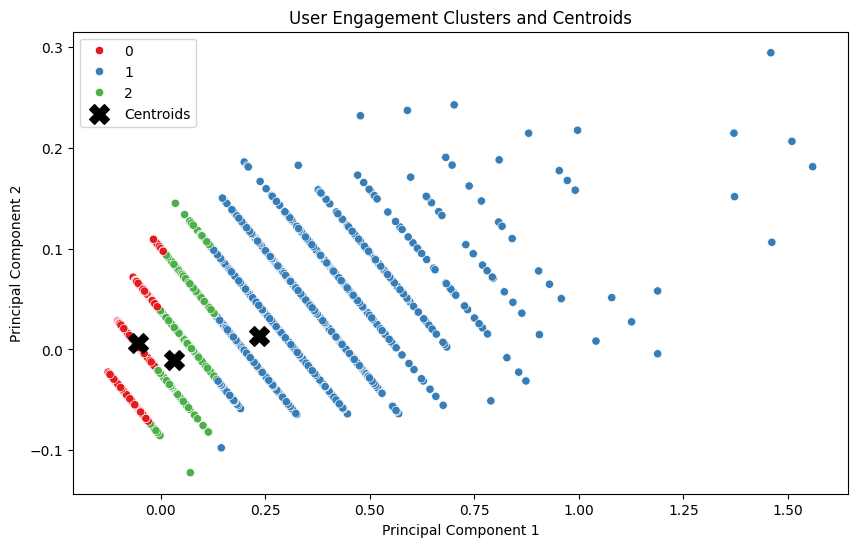

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction to visualize in 2D
pca = PCA(n_components=2)
engagement_df['PCA1'] = pca.fit_transform(engagement_df[metrics])[:, 0]
engagement_df['PCA2'] = pca.fit_transform(engagement_df[metrics])[:, 1]

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', 
    hue='Engagement Cluster', 
    palette='Set1', 
    data=engagement_df, 
    legend='full'
)

# Plotting the centroids
centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], 
            marker='X', s=200, c='black', label='Centroids')

plt.title('User Engagement Clusters and Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


### Analyzing the Clusters
- **Cluster 0 (Red)**: This cluster is positioned towards the left side of the plot, with relatively lower values on PCA1 and PCA2.
- **Cluster 1 (Green)**: This cluster is positioned between Cluster 0 and Cluster 2.
- **Cluster 2 (Blue)**: This cluster is spread out further to the right and upwards, suggesting higher values on PCA1 and PCA2.